In [1]:
import os

import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import get_element, Element
from femsolver.operator import Operator
from femsolver.jax_utils import auto_vmap 
import jax.numpy as jnp
import equinox as eqx

from typing import Callable, Optional, Tuple
import sparsejac
import sparsediffax as sd
import numpy as np

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from femsolver.plotting import STYLE_PATH


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


### Griffith's critical length

The critical length for plain strain condition is given by:

$$L_\text{G} = 2\mu \Gamma/\pi(1-\nu)\sigma_{\infty}^2$$

where $\mu$ is the shear modulus, $\Gamma$ is the fracture energy, $\nu$ is the Poisson's ratio, and $\sigma_{\infty}$ is the stress at infinity.

For plain strain condition, the effective Young's modulus is given by:

$$E_\text{eff} = \frac{E}{1-\nu^2}$$

where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.


For a specimen stretched by a prestrain $\epsilon$, the applied stress at infinity is given by:

$$\sigma_{\infty} = \epsilon /E_\text{eff}$$

In [2]:
prestrain = 0.01
nu = 0.35

E = 106e3 # N/m^2
lmbda = nu * E / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

Gamma = 15 # J/m^2
sigma_c = 20e3 # N/m^2

print(f"mu: {mu} N/m^2")
print(f"lmbda: {lmbda} N/m^2")

sigma_inf = prestrain * E

L_G = 2 * mu * Gamma / (jnp.pi * (1 - nu) * sigma_inf**2)
print(f"L_G: {L_G} m")


mu: 39259.259259259255 N/m^2
lmbda: 91604.93827160491 N/m^2
L_G: 0.5133202486434296 m


In [3]:
def generate_mesh_with_line_elements(
    nx: int,
    ny: int,
    lxs: Tuple[float, float],
    lys: Tuple[float, float],
    curve_func: Optional[Callable[[jnp.ndarray, float], bool]] = None,
    tol: float = 1e-6,
) -> Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray]]:
    """
    Generates a 2D triangular mesh for a rectangle and optionally extracts
    1D line elements along a specified curve.

    Args:
        nx: Number of elements along the x-direction.
        ny: Number of elements along the y-direction.
        lxs: Tuple of the x-coordinates of the left and right edges of the rectangle.
        lys: Tuple of the y-coordinates of the bottom and top edges of the rectangle.
        curve_func: An optional callable that takes a coordinate array [x, y] and
                    a tolerance, returning True if the point is on the curve.
        tol: Tolerance for floating-point comparisons.

    Returns:
        A tuple containing:
        - coords (jnp.ndarray): Nodal coordinates, shape (num_nodes, 2).
        - elements_2d (jnp.ndarray): 2D triangular element connectivity.
        - elements_1d (jnp.ndarray | None): 1D line element connectivity, or None.
    """

    x = jnp.linspace(lxs[0], lxs[1], nx + 1)
    y = jnp.linspace(lys[0], lys[1], ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements_2d = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements_2d.append([n0, n1, n3])
            elements_2d.append([n0, n3, n2])
    elements_2d = jnp.array(elements_2d)

    # --- 2. Extract 1D elements if a curve function is provided ---
    if curve_func is None:
        return coords, elements_2d, None

    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return coords, elements_2d, jnp.array([], dtype=int)

    return coords, elements_2d, jnp.unique(jnp.array(elements_1d), axis=0)

Generated 3321 nodes.
Generated 6400 2D triangular elements.
Found 75 1D line elements on the curve.


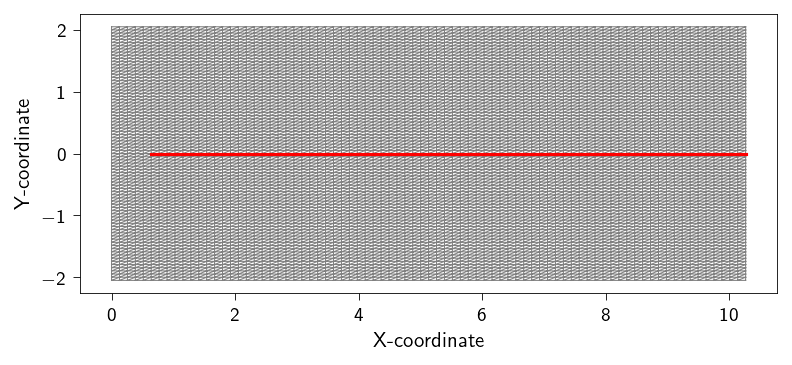

In [4]:
Nx = 80  # Number of elements in X
Ny = 40  # Number of elements in Y
Lx = 20*L_G  # Length in X
Ly = 4*L_G  # Length in Y


crack_length = 1.2*L_G

# function identifies nodes on the cohesive line at y = 0. and x > 2.0
def cohesive_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.logical_and(jnp.isclose(coord[1], 0.0, atol=tol), coord[0] > crack_length)


upper_coords, upper_elements_2d, upper_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(0, Ly), curve_func=cohesive_line
)


lower_coords, lower_elements_2d, lower_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(-Ly, -1e-6), curve_func=cohesive_line
)

coords = jnp.vstack((upper_coords, lower_coords))
elements = jnp.vstack((upper_elements_2d, lower_elements_2d + upper_coords.shape[0]))
lower_elements_1d = lower_elements_1d + upper_coords.shape[0]

print(f"Generated {upper_coords.shape[0]} nodes.")
print(f"Generated {upper_elements_2d.shape[0]} 2D triangular elements.")
print(f"Found {upper_elements_1d.shape[0]} 1D line elements on the curve.")

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)


# Highlight the extracted 1D elements in red
for edge in upper_elements_1d:
    ax.plot(upper_coords[edge, 0], upper_coords[edge, 1], "r-", lw=1.5)
for edge in lower_elements_1d:
    ax.plot(lower_coords[edge, 0], lower_coords[edge, 1], "r-", lw=1.5)

ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect("equal")
plt.show()

To check that the elements along the cohesive line are in same order on both surface, we compare the node values for the two. 

In [5]:
jnp.allclose(coords[upper_elements_1d], coords[lower_elements_1d], atol=1e-6)

Array(True, dtype=bool)

In [6]:
# --- Mesh ---
n_nodes = upper_coords.shape[0]
n_nodes += lower_coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$



In [7]:
class Material(eqx.Module):
    mu: eqx.AbstractVar[float] 
    lmbda: eqx.AbstractVar[float]

In [8]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def linear_elasticity_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


The femsolver provides a generic class `FemOperator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.

It takes three arguments:

- `compute_quads`: a function that returns the quadrature points and weights for the elements
- `compute_shape_fn`: a function that returns the shape functions for the elements
- `compute_energy`: a function that returns the energy density for the elements


In [9]:
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        value = linear_elasticity_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ

In [10]:
tri3 = get_element("tri3")
elasticity_op = ElasticityOperator(element=tri3, mu=mu, lmbda=lmbda)


In the above definition of the ``FemOperator`` class, we have used the ``quad_tri3`` and ``shape_fn_tri3`` functions to compute the quadrature points and shape functions for the triangular elements.

One can simply replace these two functions with any other quadrature and shape function. Just look at the ``quad_tri3`` and ``shape_fn_tri3`` functions in ``femsolver/quadrature.py`` to see how to define your own.

For more complex problems, one can define their own implementation of the `FemOperator` class. One just have to inherit from the `FemOperator` class and override the functions that are needed.


Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$

The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where 

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the energy-separation relationship. 

In [11]:
@eqx.filter_jit
def compute_opening(jump_quad: jnp.ndarray, nodes: jnp.ndarray) -> float:
    opening = jump_quad[1]  # we only consider the opening in the y direction
    return opening


@jax.jit
def exponential_cohesive_energy(
    delta: float,
    interface_props: dict[str, float],
    delta_threshold: float = 1e-8,
) -> float:
    delta_c = (interface_props["Gamma"] * jnp.exp(-1)) / interface_props["sigma_c"]

    def true_fun(delta):
        return interface_props["Gamma"] * (
            1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c))
        )

    def false_fun(delta):
        return 0.5 * interface_props["penalty"] * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


class CohesiveProperties(eqx.Module):
    interface_props: eqx.AbstractVar[dict[str, float]]


class CohesiveOperator(Operator, CohesiveProperties):
    element: Element
    interface_props: dict[str, float]

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes) -> float:
        """
        Compute the cohesive energy.
        """
        jump_quad, jump_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        opening_quad = compute_opening(jump_quad, nodes)
        energy = exponential_cohesive_energy(opening_quad, self.interface_props)
        return wi * energy * detJ

We define a new `Line` element to integrate the cohesive energy. The `Line` element is a 1D element that is used to integrate the cohesive energy across the cohesive interface. 

In [12]:
line2 = get_element("line2")
interface_op = CohesiveOperator(
    element=line2, interface_props={"Gamma": Gamma, "sigma_c": sigma_c, "penalty": 0.0}
)

Finally, we can put everything together to compute the total energy.

In [13]:
def _total_energy(
    u_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    elasticity_operator: Operator,
    cohesive_operator: Operator,
    upper_elements: jnp.ndarray,
    lower_elements: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        elements: Element indices.
        elasticity_operator: ElasticityOperator object.
        cohesive_operator: CohesiveOperator object.
        upper_elements: Indices of the nodes on the upper cohesive surface.
        lower_elements: Indices of the nodes on the lower cohesive surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    elastic_energy = jnp.sum(elasticity_operator.integrate(u_cell, x_cell))

    u_upper = u[upper_elements]
    u_lower = u[lower_elements]

    # we compute the jump in the displacement field across the cohesive interface
    jump_values = u_upper - u_lower

    # since the two interfaces are identical, we can use the coordinates of the upper interface
    # to intergate and compute the fracture energy
    x_upper_cell = coords[upper_elements]

    fracture_energy = jnp.sum(cohesive_operator.integrate(jump_values, x_upper_cell))

    return elastic_energy #+ fracture_energy

Since in this example, the elements along the cohesive interface (or in the two domains) are pre-determined and the position of the nodes (reference frame) remains the same throughout the simulation, we can use the `eqx.Partial` function to create a partial function that only depends on the displacement field.

In [14]:
total_energy = eqx.filter_jit(eqx.Partial(
    _total_energy,
    coords = coords,
    elements = elements,
    elasticity_operator=elasticity_op,
    cohesive_operator=interface_op,
    upper_elements=upper_elements_1d,
    lower_elements=lower_elements_1d,
))

In [15]:
total_energy(jnp.ones(n_dofs))

Array(0., dtype=float64)

## Sparsity pattern


In [16]:
def create_sparse_structure(elements, nstate, K_shape):
    # elements: (num_elements, nodes_per_element)
    elements = jnp.array(elements)
    num_elements, nodes_per_element = elements.shape

    # Compute all (i, j, k, l) combinations for each element
    i_idx = jnp.repeat(
        elements, nodes_per_element, axis=1
    )  # (num_elements, nodes_per_element^2)
    j_idx = jnp.tile(
        elements, (1, nodes_per_element)
    )  # (num_elements, nodes_per_element^2)

    # Expand for nstate
    k_idx = jnp.arange(nstate, dtype=jnp.int32)
    l_idx = jnp.arange(nstate, dtype=jnp.int32)
    k_idx, l_idx = jnp.meshgrid(k_idx, l_idx, indexing="ij")
    k_idx = k_idx.flatten()
    l_idx = l_idx.flatten()

    # For each element, get all (row, col) indices
    def element_indices(i, j):
        row = nstate * i + k_idx
        col = nstate * j + l_idx
        return row, col

    # Vectorize over all (i, j) pairs for all elements
    row_idx, col_idx = jax.vmap(element_indices)(i_idx.flatten(), j_idx.flatten())

    # Flatten and clip to matrix size
    row_idx = row_idx.flatten()
    col_idx = col_idx.flatten()
    mask = (row_idx < K_shape[0]) & (col_idx < K_shape[1])
    row_idx = row_idx[mask]
    col_idx = col_idx[mask]

    # Create the sparse structure
    indices = np.unique(np.vstack((row_idx, col_idx)).T, axis=0)
    return np.ones(indices.shape[0], dtype=jnp.int32), indices.astype(np.int32)

In [17]:
data, indices = create_sparse_structure(elements, n_dofs_per_node, (n_dofs, n_dofs))
sparsity_pattern = jax.experimental.sparse.BCOO((data, indices), shape=(n_dofs, n_dofs))

In [ ]:
x = jnp.zeros(n_dofs)
#S = sd.naive_jacfwd_sparsity(grad_E)(x)
sparsity_pattern_diffax = sd.naive_hessian_sparsity(total_energy)(x)

In [82]:
indices

array([[    0,     0],
       [    0,     1],
       [    0,     2],
       ...,
       [13283, 13281],
       [13283, 13282],
       [13283, 13283]], shape=(182088, 2), dtype=int32)

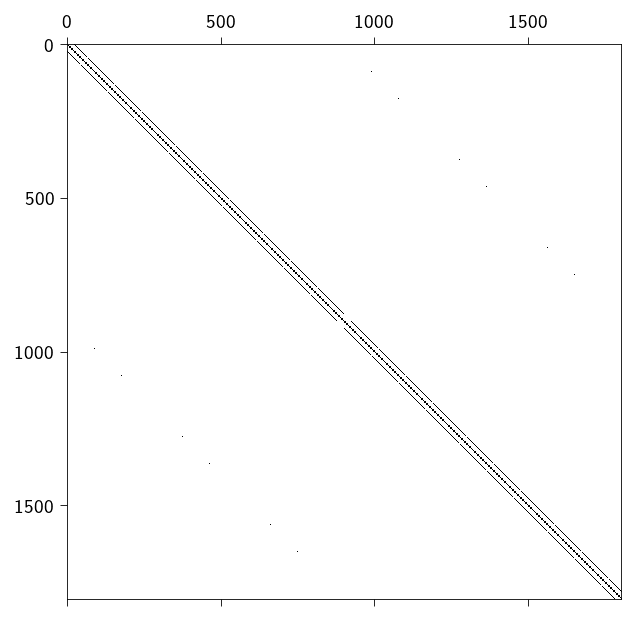

In [42]:
plt.spy(sparsity_pattern_diffax.todense())

In [ ]:
plt.spy(sparsity_pattern.todense())

In [44]:
jnp.allclose(sparsity_pattern_all.todense(), S.todense())

NameError: name 'sparsity_pattern_all' is not defined

We now locate the dofs in the two domains to apply boundary conditions.

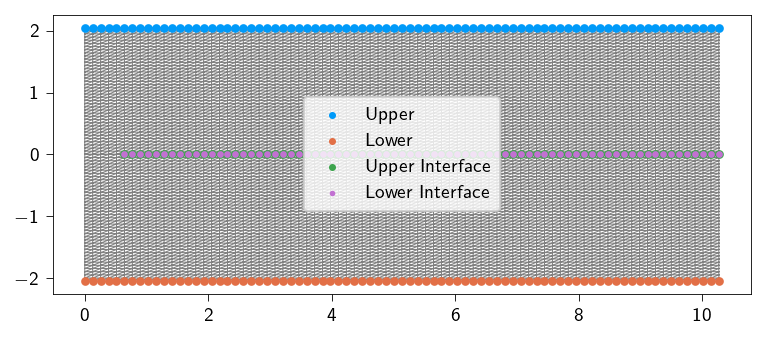

In [18]:
# --- Apply Dirichlet BCs ---
y_max = jnp.max(coords[:, 1])
y_min = jnp.min(coords[:, 1])

y_min_upper_body = jnp.min(upper_coords[:, 1])
y_max_lower_body = jnp.max(lower_coords[:, 1])

# left_upper_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] >= 0))[0]
# left_lower_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] < 0))[0]
upper_nodes = jnp.where(jnp.isclose(coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(coords[:, 1], y_min))[0]
upper_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_min_upper_body) & (coords[:, 0] > crack_length)
)[0]
lower_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_max_lower_body) & (coords[:, 0] > crack_length)
)[0]


fixed_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
        2 * upper_interface_nodes + 1,
        2 * lower_interface_nodes + 1,
    ]
)


applied_disp = prestrain * Ly

prescribed_values = jnp.zeros(n_dofs).at[2 * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * upper_nodes + 1].set(applied_disp/2.)
prescribed_values = prescribed_values.at[2 * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_nodes + 1].set(-applied_disp/2.)
prescribed_values = prescribed_values.at[2 * upper_interface_nodes + 1].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_interface_nodes + 1].set(0.0)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# --- Plot the mesh ---
# We plot the mesh the nodes that are fixed on the left and right edges.

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)

ax.scatter(coords[upper_nodes, 0], coords[upper_nodes, 1], s=10, label="Upper")
ax.scatter(coords[lower_nodes, 0], coords[lower_nodes, 1], s=10, label="Lower")
ax.scatter(
    coords[upper_interface_nodes, 0],
    coords[upper_interface_nodes, 1],
    s=10,
    label="Upper Interface",
)
ax.scatter(
    coords[lower_interface_nodes, 0],
    coords[lower_interface_nodes, 1],
    s=5,
    label="Lower Interface",
)
ax.legend()
ax.set_aspect("equal")
ax.legend(loc="center")
plt.show()

In [19]:
# define the displacement field
u = jnp.zeros(n_dofs)

# creating functions to compute the gradient and
# Hessian of the total energy using jax
gradient = jax.grad(total_energy)
hessian_sparse = sparsejac.jacfwd(gradient, sparsity=sparsity_pattern)

In [20]:
hessian_sparse_diffax = sd.jacfwd_sparse(gradient, sparsity_pattern)

In [27]:
K_sparse = hessian_sparse(u)

In [30]:
def apply_dirichlet_boundary_conditions(K_sparse_data, indices, fixed_dofs):
    K_bc_data = K_sparse_data.copy()
    for dof in fixed_dofs:
        indexes = np.where(indices[:, 0] == dof)[0]
        print(len(indexes))
        for idx in indexes:
            K_bc_data = K_bc_data.at[idx].set(0)

        idx = np.where(np.all(indices == np.array([dof, dof]), axis=1))[0]
        K_bc_data = K_bc_data.at[idx].set(1)

    return K_bc_data

In [31]:
apply_dirichlet_boundary_conditions(K_sparse.data, indices, fixed_dofs)

6
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
8
6
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
8
8
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
6
8
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
6
10
10
10
10
10
10
10
10
10
10
10
10


Array([ 8.30987654e+04,  0.00000000e+00, -4.90740741e+04, ...,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00], dtype=float64)

In [24]:
jnp.array(indices[:, 0])

Array([    0,     0,     0, ..., 13283, 13283, 13283], dtype=int32)

In [25]:
fixed_dofs.shape

(476,)

In [29]:
len(indices[:, 0])

182088

In [42]:
def get_index(indices, fixed_dof):
  return np.where(indices == fixed_dof)[0]

indexes = []
for dof in fixed_dofs:
    indexes.append(get_index(jnp.array(indices[:, 0]), dof).flatten())


(6,)

In [44]:
np.array(indexes)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (476,) + inhomogeneous part.

In [ ]:

jnp.where(indices[:, 0] == fixed_dofs[0])[0]

TypeError: eq got incompatible shapes for broadcasting: (476,), (182088,).

In [83]:
for dof in fixed_dofs:
    indexes = jnp.where(indices[:, 0] == dof)[0]
    for idx in indexes:
        print(idx)


796
797
798
799
800
801
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
21164
21165
21166
21167
21168
21169


In [63]:
from femsolver.jax_utils import auto_vmap, vmap

In [76]:
K_sparse = hessian_sparse(u)

In [77]:

K_bc_data = apply_dirichlet_boundary_conditions(
                K_sparse_data=K_sparse.data,
                indices=indices,
                fixed_dofs=fixed_dofs,
)

In [79]:
from petsc4py import PETSc

In [80]:

# ------------- Newton-Raphson Solver -------------------
def newton_solver(
    fixed_dofs,
    u_target_flat,
    n_steps,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps  # displacement increment
    u = jnp.zeros(n_nodes * n_dofs_per_node)
    fext = jnp.zeros(n_nodes * n_dofs_per_node)

    A = PETSc.Mat()
    A.createAIJ(size=(n_dofs, n_dofs))

    b = A.createVecLeft()
    du = A.createVecRight()

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

        #fext = fext.at[applied_dofs[dir]].set(applied_loading[step])
        fint = gradient(u)
        K_sparse = hessian_sparse(u)
                    
        iiter = 0
        norm_res = 1.

        while norm_res > tol and iiter < max_iter:
            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            K_bc_data = apply_dirichlet_boundary_conditions(
                K_sparse_data=K_sparse.data,
                indices=indices,
                fixed_dofs=fixed_dofs,
            )
    
            A.zeroEntries()
            for index, value in zip(indices, K_bc_data):
                row, col = index
                A.setValue(row, col, value)
            A.assemble()

            ksp = PETSc.KSP().create()
            ksp.setOperators(A)

            b.zeroEntries()
            b.setArray(residual)

            ksp.setConvergenceHistory()
            ksp.getPC().setType("none")
            du.zeroEntries()
            ksp.solve(b, du)

            ksp.destroy()

            u = u.at[:].add(du.getArray())

            fint = gradient(u)
            K_sparse = hessian_sparse(u)

            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            norm_res = jnp.linalg.norm(residual)
            print(f"  Residual: {norm_res:.2e}")

            iiter += 1
    
    return u


In [81]:
u_static = newton_solver(
    fixed_dofs=fixed_dofs,
    u_target_flat=prescribed_values,
    n_steps=10,
    tol=1e-8,
    max_iter=20,
)

Step 1/10
  Residual: 5.49e-02
  Residual: 5.46e-07
  Residual: 6.30e-12
Step 2/10
  Residual: 5.49e-02
  Residual: 5.46e-07
  Residual: 8.38e-12
Step 3/10
  Residual: 5.49e-02
  Residual: 5.46e-07
  Residual: 1.08e-11
Step 4/10
  Residual: 5.49e-02
  Residual: 5.47e-07
  Residual: 1.38e-11
Step 5/10
  Residual: 5.49e-02
  Residual: 5.47e-07
  Residual: 1.72e-11
Step 6/10
  Residual: 5.49e-02
  Residual: 5.47e-07
  Residual: 1.95e-11
Step 7/10
  Residual: 5.49e-02
  Residual: 5.47e-07
  Residual: 2.23e-11
Step 8/10
  Residual: 5.49e-02
  Residual: 5.47e-07
  Residual: 2.62e-11
Step 9/10
  Residual: 5.49e-02
  Residual: 5.48e-07
  Residual: 3.04e-11
Step 10/10
  Residual: 5.49e-02
  Residual: 5.48e-07
  Residual: 3.25e-11


Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [24]:
grad_us = elasticity_op.gradient(
    u_static.reshape(-1, n_dofs_per_node)[elements], coords[elements]
)
strains = compute_strain(grad_us)
stresses = compute_stress(strains, elasticity_op.mu, elasticity_op.lmbda)

In [47]:
# --- Visualization ---
from femsolver.plotting import STYLE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(16, 8))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors='black',
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()


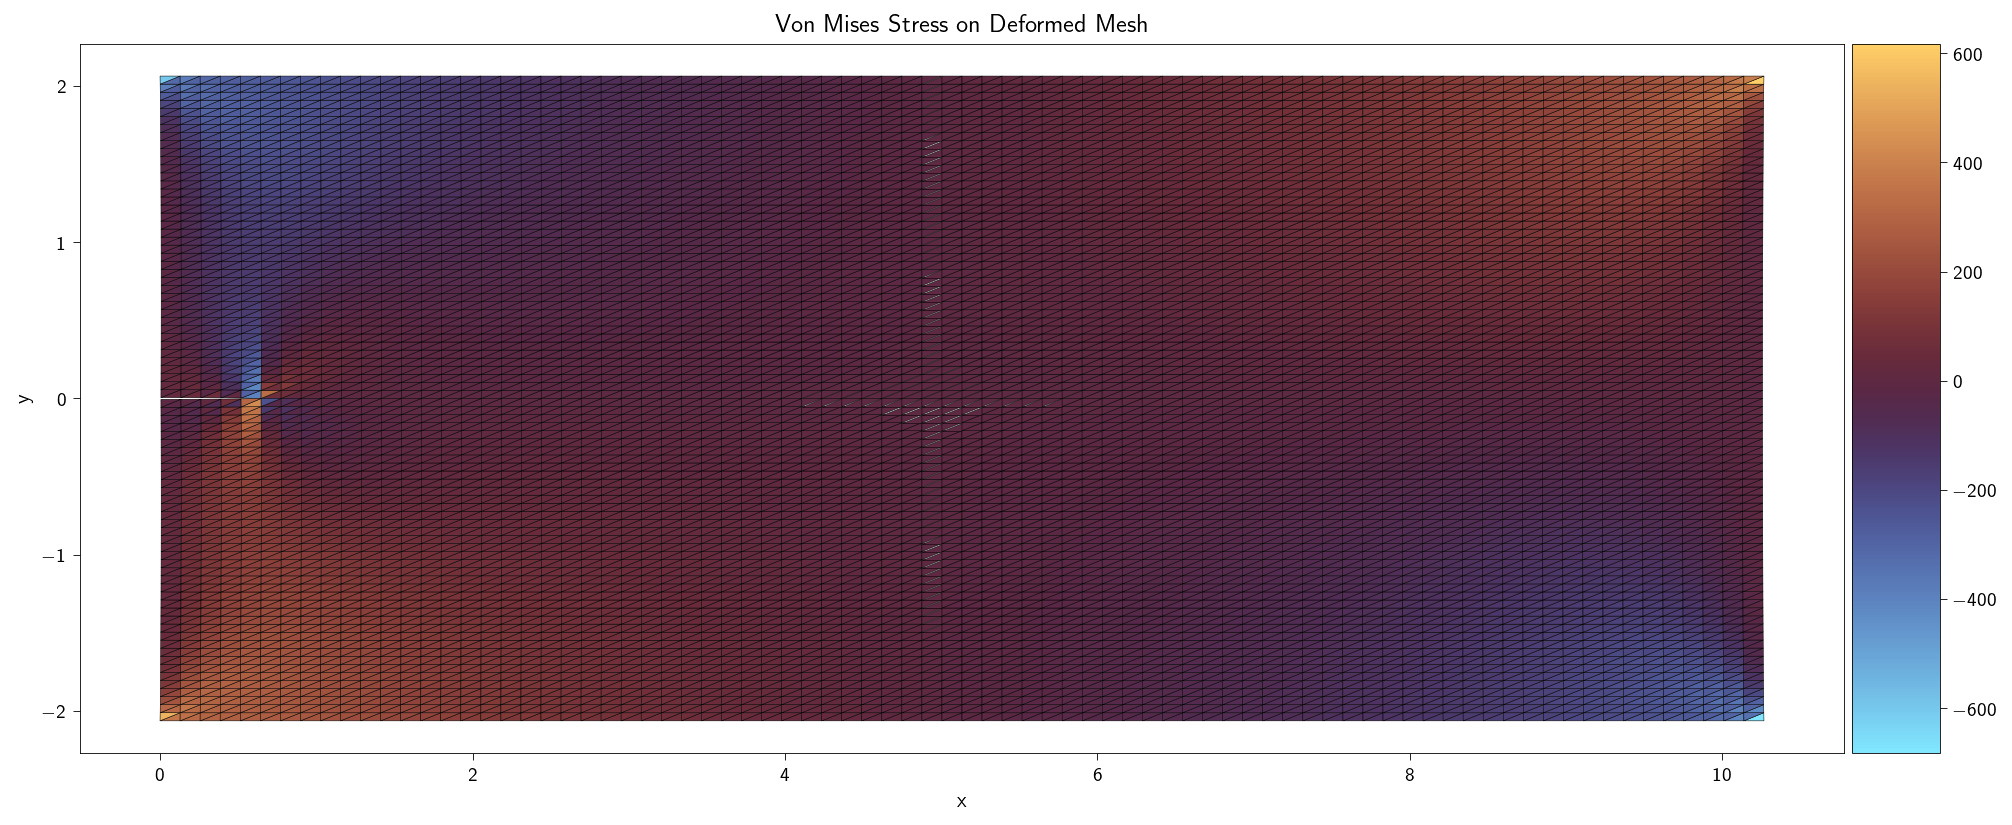

In [48]:
plot_displacement_and_stress(
    coords, u_static.reshape(-1, n_dofs_per_node), elements, stresses[:, :, 0, 1].flatten()
)

In [49]:

def plot_nodal_values(coords, u, elements, nodal_values, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        nodal_values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

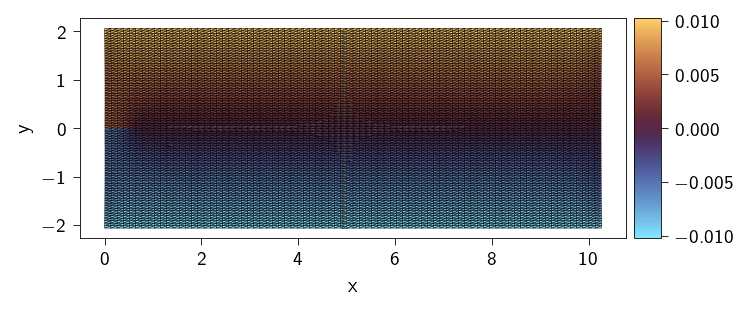

In [51]:
plot_nodal_values(
    coords,
    u_static.reshape(-1, n_dofs_per_node),
    elements,
    nodal_values=u_static.reshape(-1, n_dofs_per_node)[:, 1].flatten(),
)